<a href="https://colab.research.google.com/github/twishi03/liver/blob/master/stain-normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stain Normalization

Click to open in: \[[GitHub](https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/examples/02-stain-normalization.ipynb)\]\[[Colab](https://colab.research.google.com/github/TissueImageAnalytics/tiatoolbox/blob/master/examples/02-stain-normalization.ipynb)\]



## About this notebook

This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory. To connect with Colab, click on one of the two blue checkboxes above. Check that "colab" appears in the address bar. You can right-click on "Open in Colab" and select "Open in new tab" if the left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on GitHub or Colab, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab, set up your Python environment, as explained in the
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.



## Why normalize colour?

Pathologists usually find it easy to ignore features of a whole slide image (WSI) that are irrelevant from the point of view of diagnosis and treatment. However, this is not the case for computers. A standard hazard in digital pathology is that a computer program, developed using WSIs from one centre, gives much less impressive results when tried on WSIs from another centre. There are many factors contributing to such problems, among which are differences in colouring of WSIs from two different centres, even when the same standardised staining protocols are in force. These differences can be due to variation in slide scanners, the experience and skill of technicians, the quality and concentration of antigens, incubation time and temperature, *etc, etc*. Ideally, the same tissue specimens, stained in different laboratories, should give the same results, but this ideal appears to be unreachable. Stain normalization is a common pre-processing step, whose objective is to reduce to a minimum colour differences that have no significance in clinical practice. `tiatoolbox` makes a few different stain-normalization algorithms available to the user, and we demonstrate how to use them in this notebook.

## About this demo

In this example, we will

1. Load a sample WSI.
1. Extract a square patch.
1. Stain-normalize the tile using                                                                                                                                                                      various built-in methods.
1. Stain-normalize with a user-defined stain matrix.<br/>

During the above steps, we will be using functions from our `stainnorm` module [here](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/tiatoolbox/tools/stainnorm.py). This demo assumes some understanding of the functions in the `wsireader` module (for example by going through the demo [here](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/01-wsi-reading.ipynb)).



## Setting up the environment

### TIAToolbox and dependencies installation

You can skip the following cell if 1) you are not using the Colab plaform or 2) you are using Colab and this is not your first run of the notebook in the current runtime session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab , the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)



In [1]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail -n 1
!pip install tiatoolbox | tail -n 1

print("Installation is done.")

Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.1 which is incompatible.
google-colab 1.0.0 requires requests==2.27.1, but you have requests 2.30.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 2.0.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 2.0.0 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 2.0.0 which is incompatible.


Installation is done.


> **IMPORTANT**: If you are using Colab and you run the cell above for the first time, please note that you need to restart the runtime before proceeding through (menu) *Runtime→Restart runtime*. This is needed to load the latest versions of prerequisite packages installed with TIAToolbox. Having done so, you will then be able to manage this notebook normally, using *Runtime→Run all* or *Runtime→Run after*, or you can run the cells one by one, as you prefer.



### Removing leftovers from previous runs

This cell removes the directory `tmp` if it exists—a previous run may have created it. This cell can be skipped if you are running this notebook for the first time.



In [1]:
![ -d tmp ] && ( echo "deleting tmp directory"; rm -rf tmp )

### Importing related libraries

We start by importing some necessary modules.



In [3]:
from tiatoolbox import utils
#from tiatoolbox.wsicore.slide_info import slide_info
from tiatoolbox.wsicore import wsireader
from tiatoolbox import data
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 150  # for high resolution figure in notebook

### Downloading the required files

We load a small WSI, specified with the help of the path variable `user_sample_wsi_path` (default value `None`). Unless this None value is changed, the WSI is downloaded from the web, as seen in the code below, and saved with filename given by the variable `sample_file_name` in the directory given by `data_dir`. Data generated by the notebook is stored under data_dir, providing rapid local access.



In [8]:
data_dir = "./tmp"
sample_file_name = "/content/GTEX-OHPM-0826.svs"

user_sample_wsi_path = "/content/GTEX-OHPM-0826.svs"


def download(url_path, save_path):
    r = requests.get(url_path)
    with open(save_path, "wb") as f:
        f.write(r.content)
    return


user_sample_wsi_path = "/content/GTEX-OHPM-0826.svs"

if user_sample_wsi_path is None:
    sample_wsi_path = "%s/%s" % (data_dir, sample_file_name)
else:
    sample_wsi_path = user_sample_wsi_path
if not os.path.exists(sample_wsi_path):
    os.makedirs(os.path.dirname(sample_wsi_path))
    url_path = (
        " https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/CMU-1-Small-Region.svs"
    )
    download(url_path, sample_wsi_path)

print("Download is complete.")

Download is complete.


## Reading in a WSI

It's easy to read a WSI, and print important metadata. We plot a thumbnail version to find regions of interest.



('objective_power', 20.0)
('slide_dimensions', (31871, 21960))
('level_count', 3)
('level_dimensions', ((31871, 21960), (7967, 5490), (1991, 1372)))
('level_downsamples', [1.0, 4.000188276641145, 16.00668240317581])
('vendor', 'aperio')
('mpp', (0.4942, 0.4942))
('file_path', PosixPath('/content/GTEX-OHPM-0826.svs'))
('axes', 'YXS')


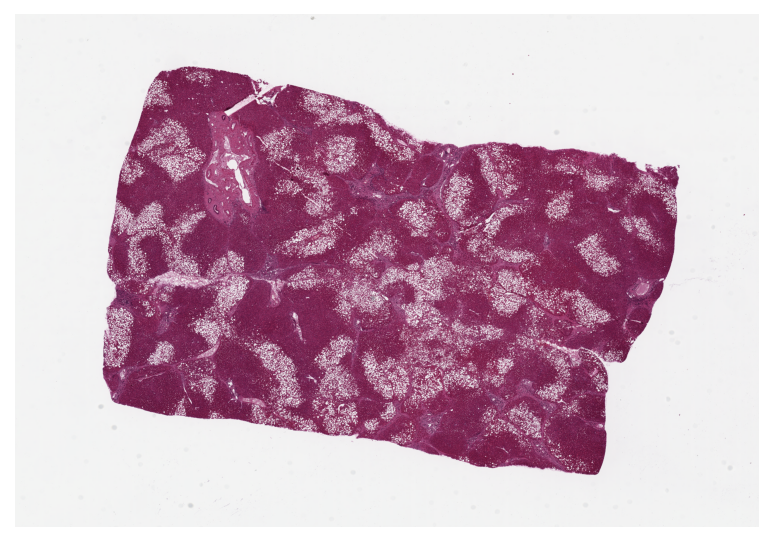

In [9]:
# create a file handler
wsi_reader = wsireader.WSIReader.open(input_img=sample_wsi_path)
wsi_info = wsi_reader.info.as_dict()
# we will print out each info line by line
print(*list(wsi_info.items()), sep="\n")
wsi_thumb = wsi_reader.slide_thumbnail(resolution=1.25, units="power")

plt.imshow(wsi_thumb)
plt.axis("off")
plt.show()

## Extract a tile from the WSI

From the figure, a $50\times50$ patch with top-left at $[50,100]$ (XY-coordinate) in the thumbnail contains both stroma and gland tissue, and is therefore suitable for demonstrating different stainings. The thumbnail is loaded at $\times1.25$ objective power and the WSI at $\times20$. To convert to the highest resolution available, we multiply coordinates by $20/1.25 = 16$, obtaining a patch (named `sample`) with $800\times800$ pixels, and with the top-left corner of the patch at XY location $[800, 1600]$.



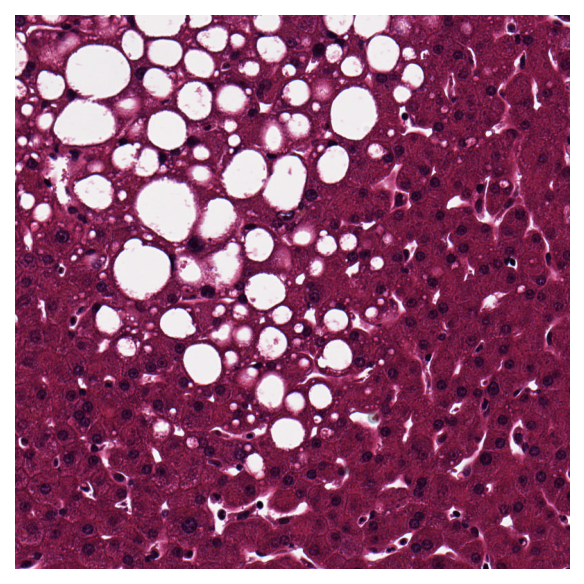

In [11]:
sample = wsi_reader.read_region(
    location=[8000, 16000], level=0, size=[800, 800]  # in X, Y
)
plt.imshow(sample)
plt.axis("off")
plt.show()

## Stain normalizing a tile



We say that an image is a *target*, if we are trying to colour other images, of different tissue, consistently with the colouring of the target. We download a different image to act as target stain.



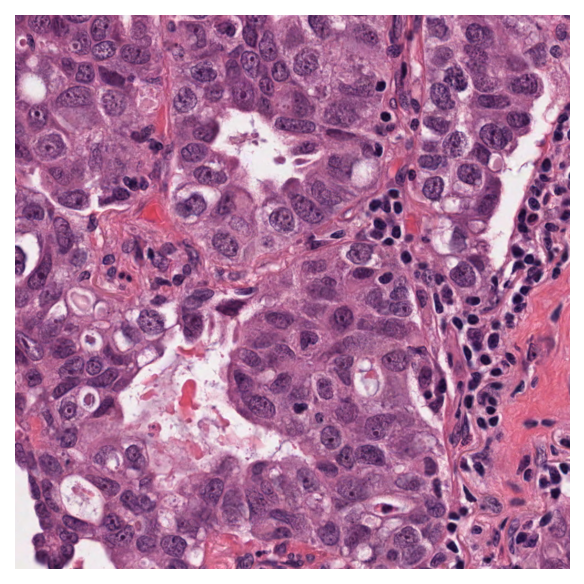

In [12]:
target_image = data.stain_norm_target()
plt.imshow(target_image)
plt.axis("off")
plt.show()

### Vahadane method



We can stain-normalize the `sample` image to the target image using the widely known [Vahadane](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7460968) method. The functionality of the normalizer is inspired by the `sklearn` calling style and is applied as follows:



  @numba.jit()

  @numba.jit()

  @numba.jit()

  @numba.jit()



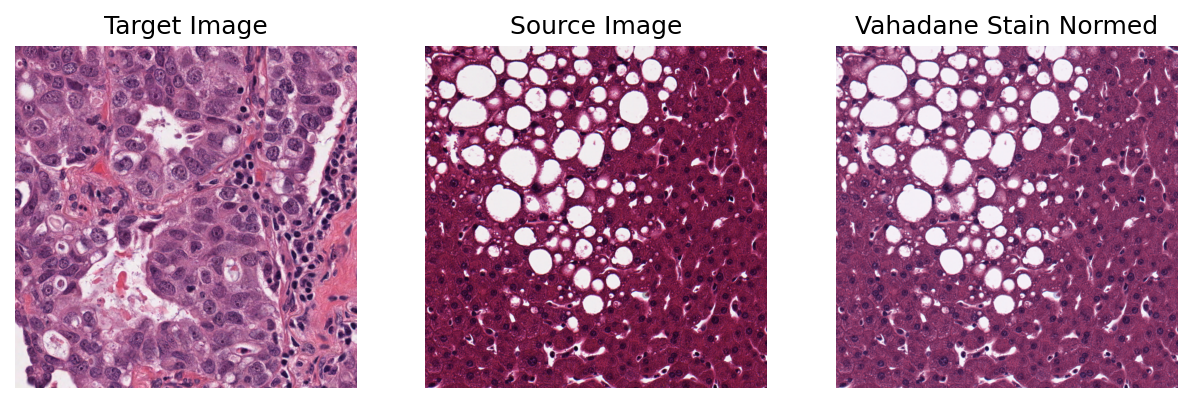

In [13]:
from tiatoolbox.tools import stainnorm

stain_normalizer = stainnorm.VahadaneNormalizer()
stain_normalizer.fit(target_image)

normed_sample = stain_normalizer.transform(sample.copy())

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(target_image)
plt.title("Target Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(sample)
plt.title("Source Image")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(normed_sample)
plt.title("Vahadane Stain Normed")
plt.axis("off")
plt.show()

### Other stain normalization methods



You can investigate one or more of the stain normalization methods we have implemented, by using either the class name as above, or our getter function `get_normalizer`. The getter function is applied to the corresponding method name. Below, we illustrate the latter approach. The stain normalization names are provided in the `method_name_list` variable. We sequentially apply each method on the `sample` image and plot them for visual comparison.



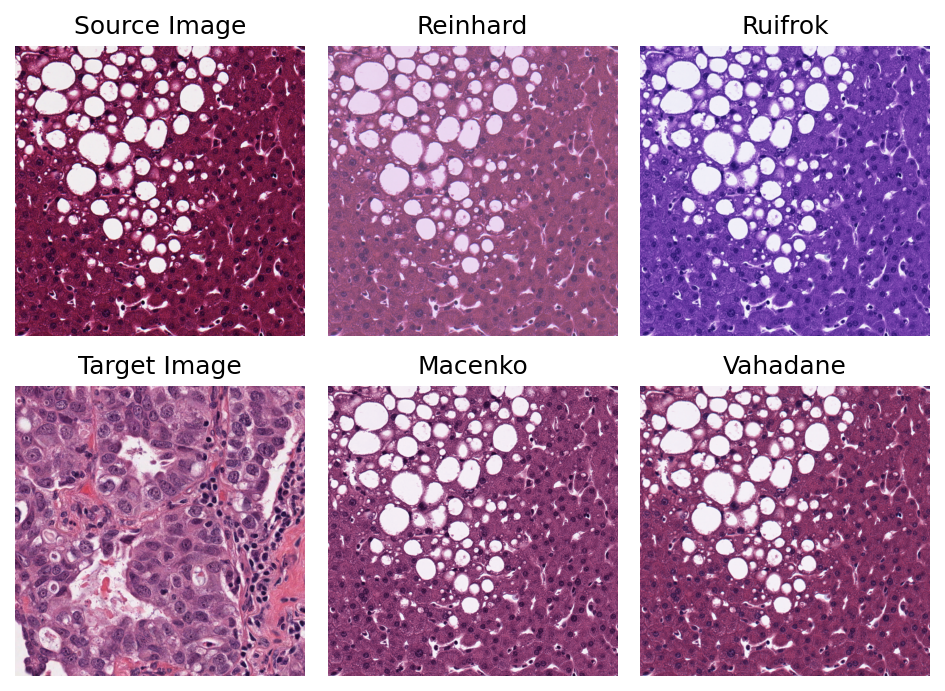

In [14]:
method_name_list = ["Reinhard", "Ruifrok", "Macenko", "Vahadane"]

plt.subplot(2, 3, 1)
plt.imshow(sample)
plt.title("Source Image")
plt.axis("off")
plt.subplot(2, 3, 4)
plt.imshow(target_image)
plt.title("Target Image")
plt.axis("off")

pos = [2, 3, 5, 6]
for idx, method_name in enumerate(method_name_list):
    stain_normalizer = stainnorm.get_normalizer(method_name)
    stain_normalizer.fit(target_image)

    normed_sample = stain_normalizer.transform(sample.copy())
    plt.subplot(2, 3, pos[idx])
    plt.imshow(normed_sample)
    plt.title(method_name.capitalize())
    plt.axis("off")
plt.tight_layout()
plt.show()

## Custom staining



In addition to the four implemented methods, you can implement and use your own method. One way is to subclass the base class `stainnorm.StainNormalizer`. Another way is to provide your own custom stain conversion matrix as input to `stainnorm.StainNormalizer`.<br/> (**Note** the former method is for advanced users only! In this notebook, we will only explore the customisation of the input stain matrix.)<br/> As an example, we use a stain matrix available from the `skimage` library, namely *Feulgen + Light Green*, a colour model inspired by Robert Feulgen's method of staining DNA. We finally compare using a custom defined stain matrix with using the Vahadane method.



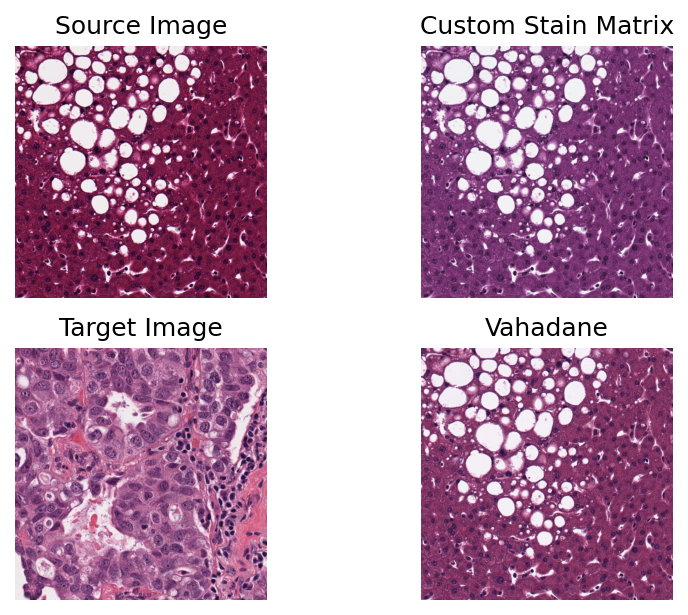

In [15]:
import skimage.color

stain_matrix = skimage.color.fgx_from_rgb[:2]
custom_normalizer = stainnorm.CustomNormalizer(stain_matrix)
custom_normalizer.fit(target_image)

vahadane_normalizer = stainnorm.VahadaneNormalizer()
vahadane_normalizer.fit(target_image)

normed_sample1 = custom_normalizer.transform(sample.copy())
normed_sample2 = stain_normalizer.transform(sample.copy())

plt.subplot(2, 2, 1)
plt.imshow(sample)
plt.title("Source Image")
plt.axis("off")
plt.subplot(2, 2, 3)
plt.imshow(target_image)
plt.title("Target Image")
plt.axis("off")
plt.subplot(2, 2, 2)
plt.imshow(normed_sample1)
plt.title("Custom Stain Matrix")
plt.axis("off")
plt.subplot(2, 2, 4)
plt.imshow(normed_sample2)
plt.title("Vahadane")
plt.axis("off")
plt.show()